In [1]:
from typing import Literal


Op = Literal['OR', 'AND', 'XOR']

values: dict[str, int] = {}
wires: dict[str, tuple[str, Op, str]] = {}


with open('24.txt') as f:
    value_raw, wire_raw = f.read().strip().split('\n\n')
    for line in value_raw.split('\n'):
        k, v = line.split(': ')
        values[k] = int(v)

    for line in wire_raw.split('\n'):
        v, k = line.split(' -> ')
        wires[k] = v.split()

# Part 1: Cross-evaluation

In [2]:
N = 0
while (k := f'z{N:02d}') in wires:
    N += 1
N

46

In [3]:
def evaluate(key: str):
    if key not in values:
        if key not in wires:
            return None
        a, op, b = wires[key]
        print(a, b)
        match op:
            case 'OR':  c = evaluate(a) | evaluate(b)
            case 'XOR': c = evaluate(a) ^ evaluate(b)
            case 'AND': c = evaluate(a) & evaluate(b)
        values[key] = c
    
    return values[key]

def get_values(k: str):
    string = ''
    N = 0
    while (bit := evaluate(f'{k}{N:02d}')) is not None:
        # print(f'{k}{N:02d}', bit)
        string += str(bit)
        N += 1
    return int(''.join(reversed(string)), 2)

get_values('z')

y00 x00
rvb qkm
x01 y01
y00 x00
hvf qfj
x02 y02
ksr svq
rvb qkm
x01 y01
kgk rgm
nps kbb
y02 x02
qfj hvf
x03 y03
ggs qdg
x04 y04
gmf dkr
y03 x03
kgk rgm
chv rpn
cjq qqg
x04 y04
ggs qdg
y05 x05
rbr pjh
x06 y06
hqr hqv
x05 y05
rpn chv
qpc svk
ckw std
pjh rbr
y06 x06
y07 x07
vdg dhv
nvr pkw
svk qpc
y07 x07
y08 x08
bnw qqr
wgh ngt
x08 y08
dhv vdg
x09 y09
msp wgr
dmb hnw
y09 x09
qqr bnw
x10 y10
qvd psh
nkv rwq
wgr msp
x10 y10
y11 x11
ctc jhf
x12 y12
kbk qps
psh qvd
x11 y11
wpw tgv
hks vwc
jhf ctc
x12 y12
x13 y13
gdr ftc
x14 y14
qnb wfg
wpw tgv
y13 x13
dnn mrm
rjm ctg
x15 y15
dqg gnc
gdr ftc
x14 y14
y15 x15
kdf qnw
y16 x16
ctg rjm
qjb bmk
y17 x17
srr mmn
kdf qnw
x16 y16
cgq mvk
swr wtp
bmk qjb
x17 y17
x18 y18
wwc qpk
nbt vrq
x18 y18
cgq mvk
x19 y19
x20 y20
hbp rjq
fkg cqr
wrb msn
mjm vct
wwc qpk
y19 x19
x20 y20
wrb msn
y21 x21
pcp nns
fdb bfk
hbp rjq
y21 x21
y22 x22
tpr kpc
tsp sgc
nns pcp
x22 y22
x23 y23
ptv htw
y24 x24
rvc qbm
kpc tpr
y23 x23
qbj tcw
x25 y25
fgn cmf
ptv htw
x24 y24
pfw hdm


48508229772400

# Part 2: Wires crossed

## A bit of analysis

We know how a half-adder works, but let's indulge a bit of network viz:

In [4]:
import networkx as nx
from pyvis.network import Network

COLORS = {
    'OR': 'red',
    'XOR': 'green',
    'AND': 'blue',
}
G = nx.DiGraph()
for k, (a, op_actual, b) in wires.items():
    G.add_node(k, color=COLORS[op_actual])
    G.add_edge(a, k, label=op_actual+'0')
    G.add_edge(b, k, label=op_actual+'1')
pos = nx.circular_layout(G)

def position(node, x, y):
    pos[node] = [x, y]
    if node in wires:
        a, _, b = wires[node]
        position(a, x+1, y)
        position(b, x+1, y - 1/2**x)

for i in range(N):
    position(f'z{i:02d}', 0, i)

net = Network(notebook=True, cdn_resources='in_line', directed=True)
net.from_nx(G)
net.show("24.html")

24.html


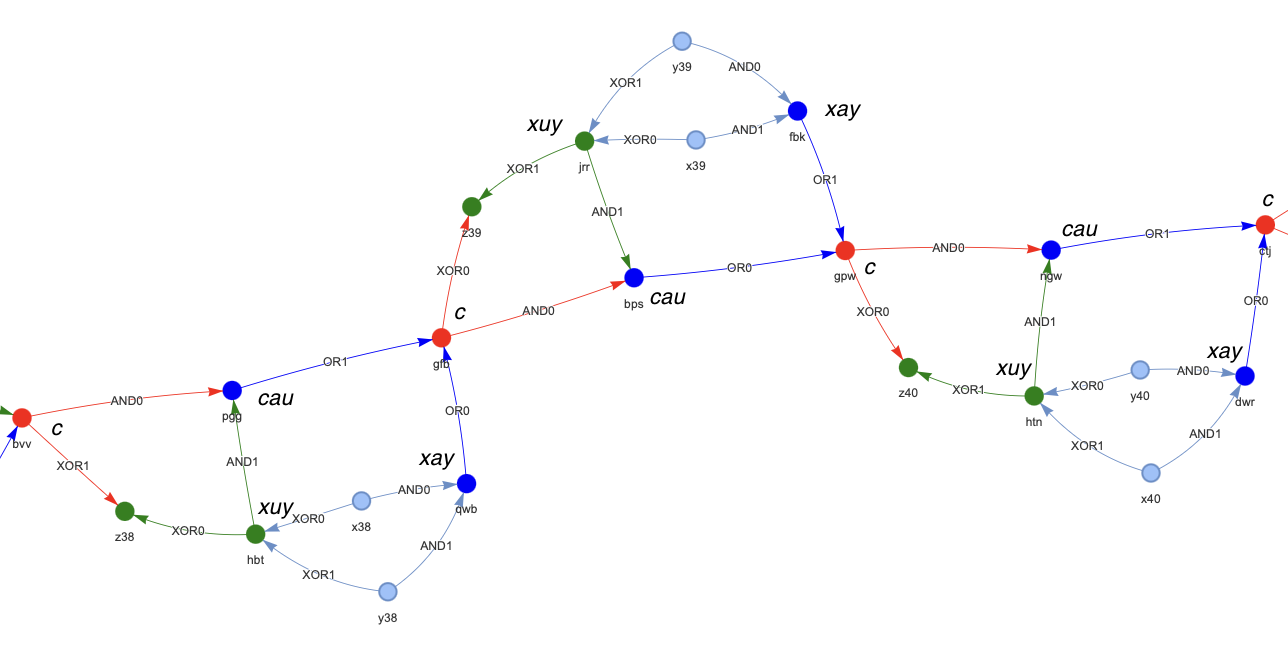

In [5]:
from IPython.display import Image
Image('24.png')

How can we spot an error? If we give each node a 'type', we can derive a common arrangement:

| Type  | Typically: |
| ----- | ---------- |
| z     | c XOR xuy  |
| xay   | x AND y    |
| xuy   | x XOR y    |
| cau   | c AND xuy  |
| c     | cau OR xay |

Notably, the final _z_ is actually just a _c_ in disguise.

There are exceptions at the start and end, but we will make two **assumptions**:
- anomalies won't be at the start or end
- anomalies won't immediately link with anomalies.

In [6]:
NodeType = Literal['z', 'xay', 'xuy', 'cau', 'c']

type_ops: dict[NodeType, Op] = {
    'z': 'XOR',
    'xay': 'AND',
    'xuy': 'XOR',
    'cau': 'AND',
    'c': 'OR'
}

type_chain: dict[tuple[NodeType, Op], NodeType] = {
    ('z', 'OR'): 'c',
    ('z', 'XOR'): 'xuy',
    ('cau', 'AND'): 'cau',
    ('cau', 'XOR'): 'xuy',
}

def op(node: str):
    _, op, _ = wires[node]
    return op


def anomaly(node: str, t: NodeType):
    if t in 'xy':
        # No rules here
        return
    
    a, op_a, b = wires[node]

    if (op_d := type_ops[t]) != op_a:
        yield node, t, op_a, op_d
    
    for n in a, b:
        if n[0] in 'xy':
            continue
        if n_typ := type_chain.get((t, op(n))):
            # print(n, n_typ)
            yield from anomaly(n, n_typ)


def all_anomalies():
    for i in range(N):
        z = f'z{i:02d}'
        typ = 'c' if i == N-1 else 'z'
        yield from anomaly(z, typ)

for a in all_anomalies():
    print(a)



('z15', 'z', 'OR', 'XOR')
('z20', 'z', 'AND', 'XOR')
('z37', 'z', 'AND', 'XOR')


Well this isn't very clear. ...wait! There's an idea!

## Attempt 2: Uhm... why not look at the bits themselves?

My, I feel a bit foolish not considering this..!

In [7]:
q = 0
for zbit, typ, _, _ in all_anomalies():
    if typ == 'z':
        z = int(zbit[1:])
        q += 1 << z

x = get_values('x')
y = get_values('y')
z = get_values('z')
diff = z^(x+y)

for c in 'x+y', 'z', 'diff', 'q', 'diff | q':
    print(f'{c:8} {bin(eval(c))[2:]:>046}')

x+y      1010111111111000101011110011100110010001110000
z        1011000001111000110011110011011110010001110000
diff     0001111110000000011000000000111000000000000000
q        0000000010000000000000000100001000000000000000
diff | q 0001111110000000011000000100111000000000000000


Let's surmise the faulty swaps are related to the bits `diff | q` to narrow our search.

In [8]:
n = diff | q
bits = [i for i in range(N) if (n>>i) % 2]
bits

[15, 16, 17, 20, 27, 28, 37, 38, 39, 40, 41, 42]

## Side consideration: Propagate

In [9]:
pointers: dict[str, set[tuple[str, Op]]] = {}

for k, (a, op, b) in wires.items():
    for n in a, b:
        pointers.setdefault(n, set()).add((k, op))

point_types = {
    ('x',  'AND'): 'xay',
    ('x',  'XOR'): 'xuy',
    ('xay', 'OR' ): 'c',
    ('xuy', 'XOR'): 'z',
    ('xuy', 'AND'): 'cau',
    ('cau', 'OR'): 'c'
}

def get_segment(i: int):
    assert pointers[f'x{i:02d}'] == pointers[f'y{i:02d}']

    segment = {'x': f'x{i:02d}'}

    for t0 in ('x', 'xuy', 'xay', 'cau'):
        if not (n := segment.get(t0)):
            # print('Expected', t0)
            continue
        ps = pointers.get(n)
        if not ps:
            continue
        for node, op in ps:
            if (t0, op) not in point_types:
                print(n, (t0, op), 'not a good type')
                continue
            t1 = point_types[t0, op]
            segment[t1] = node
    return segment

swaps = [('ncd', 'nfj')]

for i in range(1, 45):
    seg = get_segment(i)

    if not all(t in seg for t in ('x', 'xuy', 'xay', 'cau', 'c', 'z')):
        print(seg)
        print('^ missing')
        continue
    
    if not seg['z'].startswith('z'):
        # z is badly wired
        for t in ('cau', 'c', 'xuy', 'xay'):
            if seg[t].startswith('z'):
                swaps.append((seg['z'], seg[t]))

swaps




ncd ('xuy', 'OR') not a good type
nfj ('xay', 'AND') not a good type
nfj ('xay', 'XOR') not a good type
{'x': 'x27', 'xuy': 'ncd', 'xay': 'nfj'}
^ missing


[('ncd', 'nfj'), ('qnw', 'z15'), ('cqr', 'z20'), ('vkg', 'z37')]

We found the z-swaps, but there is still just one more - the XOR and AND of x27,y27 being swapped. No problem; we'll spot that by hand:

In [10]:
','.join(sorted(n for (a,b) in swaps for n in (a,b)))

'cqr,ncd,nfj,qnw,vkg,z15,z20,z37'